### Midterm Practice
*   Part I: Lectures 1 - 8 (see Notebook: Midterm Review -- Lectures 1-8)
*   Part II: Lectures 9 - 10 

_Includes some homework questions and pop quizzes_

#### _Part II:_
*   _Artificial Neural Networks (ANN)_
*   _Convolutional Neural Networks (CNN)_

In [5]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt

Exercise 1: Build a CNN model composed of two convolutional layers with kernel size = 3, stride = 1, and padding = 1, in addition to two fully-connected layers. Use the neural network to train and test images from the FashionMNIST Dataset

In [49]:
torch.manual_seed(0)

# load the training & testing datasets 
train_data = datasets.FashionMNIST(
    root = '~/Downloads/',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root = '~/Downloads/',
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

# create dataloaders for each set of data
train_dataloader = DataLoader(train_data, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = True)

In [50]:
print('Classes: ', train_data.classes)
print('Total: ', len(train_data.classes))

Classes:  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Total:  10


In [51]:
print('Class To Index:\n', train_data.class_to_idx)

idx_to_class = {value : key for key, value in train_data.class_to_idx.items()}
print('\nIndex to Class:\n', idx_to_class)

Class To Index:
 {'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}

Index to Class:
 {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


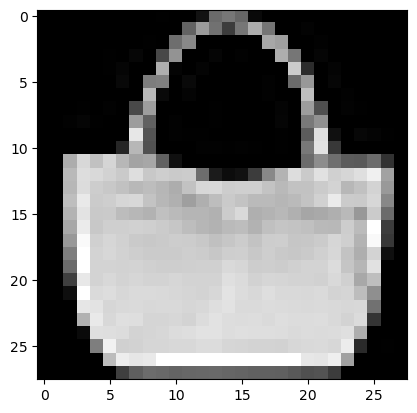

In [55]:
type(train_data[0])                                     # tuple
train_data[0][0].shape                                  # size is 1 x 28 x 28 --> i.e., grayscale image with 28 x 28 dimensions  

train_data[0]                                           # object composed of image (X) and label (Y)
train_data[0][0]                                        # image
train_data[0][1]                                        # label
plt.imshow(train_data[100][0][0, :, :], cmap = 'gray')  # note that matplotlib expects the image as 28 x 28, not 1 x 28 x 28
                                                        # you can't simply plot train_data[0][0] --> shape is 1 x 28 x 28
                                                        # basically [0, :, :] --> [channel, rows, cols]
                                                        # we want to get all rows and cols from only the first channel (grayscale)

In [58]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [85]:
class fashionCNN(nn.Module):
    def __init__(self):
        super(fashionCNN, self).__init__()
    
        # define the neural network
        self.network = nn.Sequential(
            # 2D Convolutional Layers
            nn.Conv2d(in_channels = 1, out_channels = 4, kernel_size = 3, stride = 1, padding = 1),     # input: 1 x 28 x 28
                                                                                                        # output: 4 x 28 x 28
                                                                                                        # 4 filters of size 3 x 3
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),                                                  
            nn.Conv2d(in_channels = 4, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),     # input: 4 x 28 x 28
                                                                                                        # output: 8 x 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            # Fully-Connected Layers
            nn.Flatten(),                                                                               # vectorize input

            nn.Linear(in_features = 392, out_features = 512), 
            nn.ReLU(),

            nn.Linear(in_features = 512, out_features = 256),
            nn.ReLU(),

            nn.Linear(in_features = 256, out_features = 10)                                             # 10 classes = 10 output features
                                                                                                        # don't apply ReLU, use logsoftmax
        )
    
    def forward(self, x):
        return self.network(x)

In [86]:
cnn = fashionCNN()
cnn.to(device)
print(cnn)

fashionCNN(
  (network): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=392, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=256, bias=True)
    (10): ReLU()
    (11): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [87]:
criteria = nn.CrossEntropyLoss()                                # loss function that applies logsoftmax
                                                                # can also use nn.NLLLoss, but you have to use logsoftmax on output layer
optimizer = optim.Adam(params = cnn.parameters(), lr = 0.001)

In [88]:
# Training the Model
trainingHistory = []
validationHistory = []

# train the model
cnn.train()
for epoch in range(10):
    trainingLoss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 1. Forward Pass
        optimizer.zero_grad()
        outputs = cnn(inputs)

        # 2. Backward Pass
        loss = criteria(outputs, labels)
        loss.backward()

        # 3. Update Parameters
        optimizer.step()

        trainingLoss += loss.item()
    
    # validation
    with torch.no_grad():
        validationLoss = 0.0
        for data in test_dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = cnn(inputs)
            loss = criteria(outputs, labels)

            validationLoss += loss.item()
    
    print(f'Epoch [{epoch} / {9}] --> Training Loss: {trainingLoss / len(train_data)} | Validation Loss: {validationLoss / len(test_data)}')
    trainingHistory += [trainingLoss / len(train_data)]
    validationHistory += [validationLoss / len(test_data)]

print('\nFinished Training')

Epoch [0 / 9] --> Training Loss: 0.009353949559231599 | Validation Loss: 0.007306032535433769
Epoch [1 / 9] --> Training Loss: 0.0061243277641634146 | Validation Loss: 0.00646719087511301
Epoch [2 / 9] --> Training Loss: 0.005312722942108909 | Validation Loss: 0.0055664206355810165
Epoch [3 / 9] --> Training Loss: 0.004704969980816046 | Validation Loss: 0.005157681077718735
Epoch [4 / 9] --> Training Loss: 0.004350650290275614 | Validation Loss: 0.0049840166695415975
Epoch [5 / 9] --> Training Loss: 0.004024245562528571 | Validation Loss: 0.004584648855030537
Epoch [6 / 9] --> Training Loss: 0.0037550819839040437 | Validation Loss: 0.004478497125208378
Epoch [7 / 9] --> Training Loss: 0.0035379642338802418 | Validation Loss: 0.004448762955516577
Epoch [8 / 9] --> Training Loss: 0.0033160456591596207 | Validation Loss: 0.004464381533116102
Epoch [9 / 9] --> Training Loss: 0.0030985555728897454 | Validation Loss: 0.004313825476914644

Finished Training


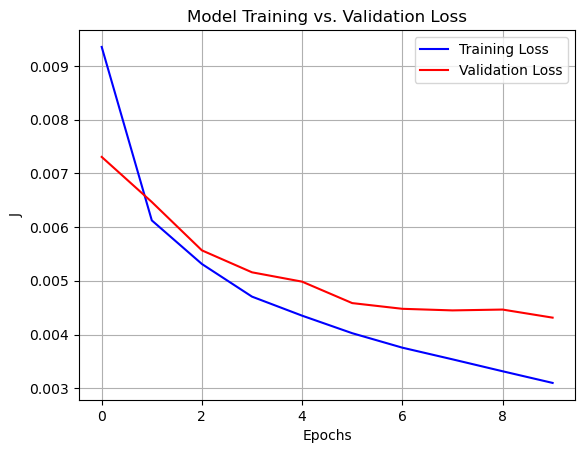

In [89]:
# Plot the training and validation losses
plt.plot(trainingHistory, 'b', label = 'Training Loss')
plt.plot(validationHistory, 'r', label = 'Validation Loss')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('J')
plt.title('Model Training vs. Validation Loss')
plt.grid(visible = True)
plt.show()

Actual: Dress 		 Predicted: Dress
Actual: Bag 		 Predicted: Bag
Actual: Sandal 		 Predicted: Sandal
Actual: T-shirt/top 		 Predicted: T-shirt/top
Actual: Sandal 		 Predicted: Sandal
Actual: Coat 		 Predicted: Pullover
Actual: Bag 		 Predicted: Bag
Actual: Pullover 		 Predicted: Pullover
Actual: Sandal 		 Predicted: Sandal
Actual: Bag 		 Predicted: Bag


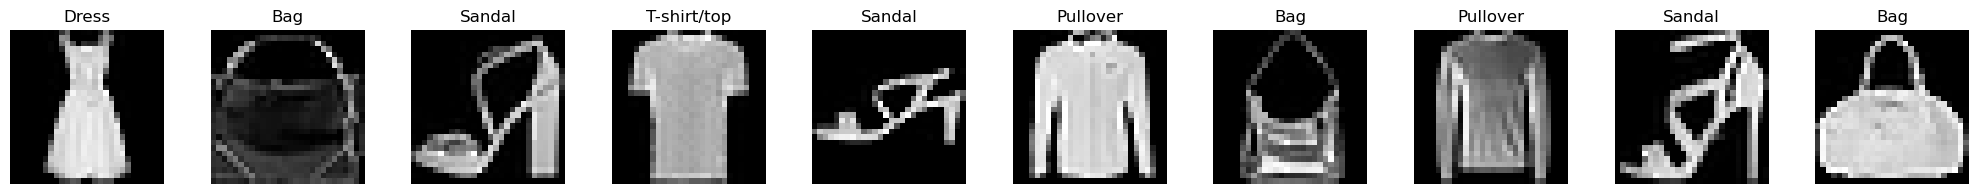

In [93]:
# Test the Model
images, labels = next(iter(test_dataloader))
images = images.to(device)
labels = labels.to(device)

outputs = cnn(images)
_, predictions = torch.max(outputs, dim = 1)

plt.figure(figsize = (20, 30))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.tight_layout()
    plt.imshow(images[i][0, :, :], cmap = 'gray')
    plt.axis('off')
    plt.title(idx_to_class[predictions[i].item()])
    print(f'Actual: {idx_to_class[labels[i].item()]} \t\t Predicted: {idx_to_class[predictions[i].item()]}')
plt.show()

In [94]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = cnn(images)
        _, predictions = torch.max(outputs, dim = 1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()

print(f'Accuracy of the Network on the {total} Test Images: {100 * correct / total}%')

Accuracy of the Network on the 10000 Test Images: 90.35%


In [96]:
with torch.no_grad():
    y_true = []  # list to store ground truth labels
    y_pred = []  # list to store predicted labels

    for testing_batch in test_dataloader:
        images, labels = testing_batch

        images = images.to(device)
        labels = labels.to(device)

        predicted_labels = cnn(images)
        _, predictions = torch.max(predicted_labels, 1)

        # append ground truth labels and predictions to the respective lists
        y_true.extend(labels.tolist())
        y_pred.extend(predictions.tolist())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average = 'macro')
    recall = recall_score(y_true, y_pred, average = 'macro')
    f1 = f1_score(y_true, y_pred, average = 'macro')
    report = classification_report(y_true, y_pred, target_names = test_data.classes)

    print("Overall Model Performance:\n")
    print(f'- Accuracy: {accuracy * 100:.2f} %')
    print(f'- Precision: {precision * 100:.2f} %')
    print(f'- Recall: {recall * 100:.2f} %')
    print(f'- F1-score: {f1 * 100:.2f} %')

    print(f'\nIndividual Class Performance:\n\n {report}')

Overall Model Performance:

- Accuracy: 90.35 %
- Precision: 90.43 %
- Recall: 90.35 %
- F1-score: 90.34 %

Individual Class Performance:

               precision    recall  f1-score   support

 T-shirt/top       0.82      0.88      0.85      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.89      0.81      0.85      1000
       Dress       0.89      0.92      0.91      1000
        Coat       0.82      0.86      0.84      1000
      Sandal       0.96      0.99      0.97      1000
       Shirt       0.76      0.73      0.74      1000
     Sneaker       0.94      0.97      0.95      1000
         Bag       0.99      0.96      0.97      1000
  Ankle boot       0.99      0.94      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

